# Introduction

This project is about teeth desease detection and classification. The first step invlove collecting data from folder and building pytorch dataset. Next a Faster RCNN model is finetuned on the dataset. Desired metrics are computed to evaluate training and finally we use the model to make prediction on x_ray image




# Imports

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd

import tensorflow as tf
import glob
import random
import cv2
from random import shuffle


import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
import torchvision
import torchvision.models.detection

from PIL import Image
import collections
import time
import copy
import sys

from google.colab import drive
import zipfile
import os
import json
import matplotlib.patches as patches


from torch.cuda.amp import GradScaler, autocast
import gc
import pickle

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Data folder



In [37]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# Define the new directory path
new_directory = '/content/drive/MyDrive/All_Projects/AI FOR HEALTHCARE/FINAL_PROJECT/DATA'

# Change current directory
os.chdir(new_directory)

In [39]:
#----- Loading training data

# Define the path to the zip file
zip_file_path = 'quadrant-enumeration-disease-train.zip'

# Define the directory where you want to extract the contents
data = '/content/teeth_data'

# Create the extraction directory if it doesn't exist
os.makedirs(data, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the contents of the zip file (preserving directory structure)
    zip_ref.extractall(data)

In [40]:
#----- Loading testing data

# Define the path to the zip file
zip_file_path = 'quadrant_enumeration_disease-test.zip'

# Define the directory where you want to extract the contents
data = '/content/teeth_data'

# Create the extraction directory if it doesn't exist
os.makedirs(data, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the contents of the zip file (preserving directory structure)
    zip_ref.extractall(data)

# List the extracted files and directories
print("Contents of the extraction directory:")
for root, dirs, files in os.walk(data):
    for file in files:
        print(os.path.join(root, file))

Contents of the extraction directory:
/content/teeth_data/__MACOSX/._quadrant_enumeration_disease
/content/teeth_data/__MACOSX/._quadrant-enumeration-disease
/content/teeth_data/__MACOSX/quadrant_enumeration_disease/._.DS_Store
/content/teeth_data/__MACOSX/quadrant_enumeration_disease/._xrays
/content/teeth_data/__MACOSX/quadrant_enumeration_disease/xrays/._val_3.png
/content/teeth_data/__MACOSX/quadrant_enumeration_disease/xrays/._val_5.png
/content/teeth_data/__MACOSX/quadrant_enumeration_disease/xrays/._val_21.png
/content/teeth_data/__MACOSX/quadrant_enumeration_disease/xrays/._val_9.png
/content/teeth_data/__MACOSX/quadrant_enumeration_disease/xrays/._val_39.png
/content/teeth_data/__MACOSX/quadrant_enumeration_disease/xrays/._val_49.png
/content/teeth_data/__MACOSX/quadrant_enumeration_disease/xrays/._val_41.png
/content/teeth_data/__MACOSX/quadrant_enumeration_disease/xrays/._val_26.png
/content/teeth_data/__MACOSX/quadrant_enumeration_disease/xrays/._val_22.png
/content/teeth_d

Note that we have 3 folders. The first one is `img` which contains the raw images. `mask` contains ground truth lung segmentation. `ann` contains annotation. For this segmentation task we are using `img` and `mask`

# Building Datasets

In [41]:
# Change current directory
data_directory = '/content/teeth_data/quadrant-enumeration-disease'
os.chdir(data_directory)

The following step is extracting relevant data

* images
* images dimenssions
* desease teeth bbox
* desease annotations from the data folder

all data is collecting in a set of python list

In [42]:
# Define the file path (adjust the path as needed)
file_path = 'train_quadrant_enumeration_disease.json'

# Open the JSON file
with open(file_path, 'r') as file:
    # Load the JSON data
    data = json.load(file)

img_id = []
img_height = []
img_width = []
img_file_name = []
for img in data['images']:
  img_id.append(img['id'])
  img_file_name.append(img['file_name'])
  img_height.append(img['height'])
  img_width.append(img['width'])


ann_img_id = []
ann_id = []
ann_bbox = []
ann_category = []
for ann in data['annotations']:
  ann_img_id.append(ann['image_id'])
  ann_id.append(ann['id'])
  ann_bbox.append(ann['bbox'])
  ann_category.append(ann['category_id_3'])

ann_category = [x + 1 for x in ann_category]

The following step is building a pytorch dataset class. A dataset object is built using all data pulled in the privious step.
Each image is resized by the transform operation, to have uniform dimmension in image distribution. A sample calling return :
* an image
* List of desease teeth bbox
* List of desease label


In [43]:


class ImageDataset(Dataset):
    def __init__(self, img_id, img_file_name, ann_img_id, ann_id, ann_bbox, ann_category, img_dir,img_height,img_width,new_size, transform=None):
        self.img_id = np.array(img_id) - 1
        self.img_file_name = np.array(img_file_name)
        self.ann_img_id = np.array(ann_img_id) - 1
        self.ann_id = np.array(ann_id) - 1
        self.ann_bbox = np.array(ann_bbox)
        self.ann_category = np.array(ann_category)
        self.img_height = np.array(img_height)
        self.img_width = np.array(img_width)
        self.img_dir = img_dir
        self.transform = transform
        self.max_ann = 0
        self.min_ann = 500
        self.new_size = new_size

        # Create a mapping from image_id to file_name
        self.id_to_filename = {i: img_file_name[i] for i in range(len(img_id))}

        # Create a mapping from image_id to annotations
        self.id_to_annotations = {}
        for i in range(len(img_id)):

            indices = np.where(self.ann_img_id == i)[0]


            if len(indices) > self.max_ann :
                self.max_ann = len(indices)
            if len(indices) < self.min_ann :
                self.min_ann = len(indices)

            if (i not in self.id_to_annotations) :
                self.id_to_annotations[i] = {'ann_id':[],
                                             'boxes':[],
                                             'labels':[]}
                for k in indices:
                    original_bbox = ann_bbox[k]
                    original_width = self.img_width[i]
                    original_height = self.img_height[i]

                    bb = self.bbox_converter(original_bbox,original_width,original_height)

                    self.id_to_annotations[i]['boxes'].append(bb)
                    self.id_to_annotations[i]['labels'].append(ann_category[k])

        for i in range(len(img_id)):
            LEN = len(self.id_to_annotations[i]['boxes'])

            self.id_to_annotations[i]['boxes'].extend([[0,0,0,0]]*(self.max_ann - LEN))
            self.id_to_annotations[i]['labels'].extend([5]*(self.max_ann - LEN))



    def bbox_converter(self,original_bbox,original_width,original_height):
        # New image dimensions
        new_width = self.new_size[1]
        new_height = self.new_size[0]

        # Calculate the scaling factors
        scale_x = new_width / original_width
        scale_y = new_height / original_height

        # Scale the bounding box coordinates
        new_bbox = [
            original_bbox[0] * scale_x, # # x1
            original_bbox[1] * scale_y, # # y1
            original_bbox[2] * scale_x, #  # width
            original_bbox[3] * scale_y # # height
        ]
        return new_bbox

    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):


        img_id = self.img_id[idx]
        img_path = os.path.join(self.img_dir, self.id_to_filename[img_id])

        image = Image.open(img_path).convert("RGB")

        # Get annotations for the image

        annotations = self.id_to_annotations.get(img_id, [])


        # Prepare the target dictionary for detection
        target = {
            'boxes': torch.tensor(annotations['boxes'], dtype=torch.float32),
            'labels': torch.tensor(annotations['labels'], dtype=torch.int64)
        }

        if self.transform:
            image = self.transform(image)



        return image, target


The following consist of building a dataset object and split it into train (80 %) and validation (20% )

In [44]:
# Define transforms

new_size = (112, 224)

transform = transforms.Compose([
    transforms.Resize(new_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset
img_dir = 'xrays'
dataset = ImageDataset(img_id, img_file_name, ann_img_id, ann_id, ann_bbox, ann_category, img_dir,img_height,img_width,new_size, transform=transform)

# Define the split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
bs = 4
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=2)


classes = ('Background','Impacted', 'Caries', 'Periapical Lesion', 'Deep Caries', 'Padding_bbox')

The following step display a sample and all bbox and labels. A Padding_bbox (and label) [0,0,0,0] is added for implementation purpose

<Figure size 640x480 with 0 Axes>

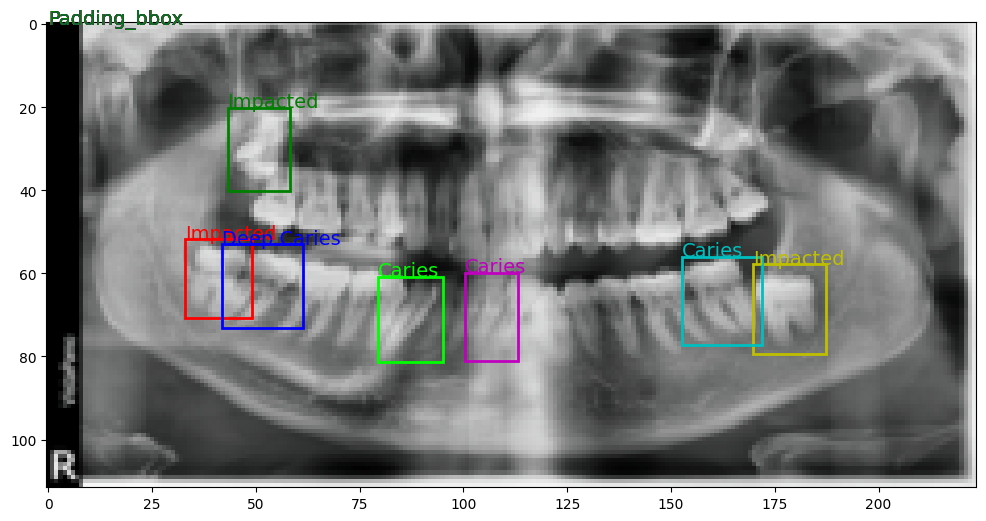

In [45]:
def imshow(img, label, bbox):

    """
      Displaying a data sample (image, labels, bbox)
    """
    image = np.copy(img[0])
    image = torch.from_numpy(image)
    image = image.cpu()
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    colors = ['r', 'b', 'g', 'y', 'c', 'm', 'lime', 'orange', 'pink', 'purple']*10
    i=0
    for bbox,label in zip(bbox,label):

        x1, y1, box_w, box_h = bbox.numpy().reshape(-1)
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                                edgecolor=colors[i], facecolor='none');
        ax.add_patch(bbox);
        ax.annotate(classes[label], (x1, y1), color=colors[i], fontsize=14);
        i+=1


# Displaying a sample from the train dataset
sample = next(iter(train_loader))
imshow(sample[0],sample[1]['labels'][0],sample[1]['boxes'][0])

# Faster R-CNN Model Trainning

## All Helper functions definition

Difining the following helper functions : <br>
- **Averager** : Python class to average loss over epochs iterations
- **training_loop** : Train a model on a train_set and validate on a val_set. Return trainning losses over iteration and ACC, AVG_PRECISION, AVG_RECALL over iteration on the validation set
- **plot_training_results** : Takes as training_loop outputs as input and plot them
- **evaluation** : Compute the following metrics on a given set (ACC, AVG_PRECISION, AVG_RECALL)
- **compute_metrics** : Compute the following metrics on a given sample prediction (ACC, AVG_PRECISION, AVG_RECALL). This function is used in evalution as helper
- **process_bbox** : Convert back bbox in the desired format after model output
- **apply_nms** : As the model output a lot of overlapping bboxes, this function used a thershold to only select non-overlapping bboxes, using non maximum suppression

In [46]:

class Averager:
    """
    Average losses computation during training
    """
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


def training_loop(model,epochs,patience,lr,train_loader,val_loader):

    # Training
    loss_hist = Averager()
    itr = 1
    lossHistoryiter = []
    lossHistoryepoch = []

    # validation
    ACC = []
    PRECISION = []
    RECALL = []

    # Early stopping parameters
    patience = patience
    best_train_loss = float('inf')
    patience_counter = 0

    # Training time setting
    start = time.time()

    # Training params setting
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
    num_epochs = epochs

    # Starting Training

    for epoch in range(num_epochs):
        model.train()
        loss_hist.reset()

        for samples in train_loader:

            # Move images and annotations to the device
            images = [image.to(device) for image in samples[0]]
            boxes = [box.to(device) for box in samples[1]['boxes']]
            labels = [label.to(device) for label in samples[1]['labels']]

            targets = []
            for i in range(len(images)):
                d = {}

                # Filter out padding boxes and labels
                valid_indices = boxes[i].sum(dim=1) != 0  # Assuming padding boxes are zeroed
                valid_boxes = boxes[i][valid_indices]
                valid_labels = labels[i][valid_indices]

                bb_copy = valid_boxes.clone()
                bb_copy[:, 0] = valid_boxes[:, 0]  # x_min = x1
                bb_copy[:, 1] = valid_boxes[:, 1] - valid_boxes[:, 3]  # y_min = y1 - box_h
                bb_copy[:, 2] = valid_boxes[:, 0] + valid_boxes[:, 2]  # x_max = x1 + box_w
                bb_copy[:, 3] = valid_boxes[:, 1]  # y_max = y1

                d['boxes'] = bb_copy  # [x_min, y_min, x_max, y_max]
                d['labels'] = valid_labels
                targets.append(d)

            output = model(images, targets)

            losses = sum(loss for loss in output.values())
            loss_value = losses.item()

            loss_hist.send(loss_value)
            lossHistoryiter.append(loss_value)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            # Optionally clear memory at the end of each epoch
            del images, targets, output, losses
            gc.collect()
            torch.cuda.empty_cache()

            if itr % 50 == 0:
                print(f"Iteration #{itr} loss: {loss_value}")
            itr += 1

        # Validation step
        val_accuracy, val_Avg_precision, val_Avg_recall = evaluation(model,val_loader)
        ACC.append(val_accuracy)
        PRECISION.append(val_Avg_precision)
        RECALL.append(val_Avg_recall)

        # Early stopping check on validation accuracy
        if loss_hist.value < best_train_loss:
            best_train_loss = loss_hist.value
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch} epochs.")
                break

        # Update the learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()
        lossHistoryepoch.append(loss_hist.value)
        print(f"=> Epoch #{epoch} train_loss: {loss_hist.value} ")


    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Time taken to Train the model :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    return model, lossHistoryepoch, ACC, PRECISION, RECALL


def plot_training_results(num_epochs,lossHistoryepoch,ACC,PRECISION,RECALL):
    """
    Plotting outputs of training
    """

    #----- Ploting loss over iteration
    x = [i for i in range(num_epochs)]
    y = lossHistoryepoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x,y=y,
                        mode='lines',
                        name='Training Loss'))

    fig.update_layout(title='Loss vs Epochs',
                      xaxis_title='Epochs',
                      yaxis_title='Loss')
    fig.show()

    #------ Ploting Validation ACCURACY, PRECISION, RECALL over iteration
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x,y=ACC,
                        mode='lines',
                        name='Accuracy'))

    fig.add_trace(go.Scatter(x=x,y=PRECISION,
                        mode='lines',
                        name='Precision'))

    fig.add_trace(go.Scatter(x=x,y=RECALL,
                        mode='lines',
                        name='Recall'))

    fig.update_layout(title='ACC,PRECISION,RECALL vs Epochs',
                      xaxis_title='Epochs',
                      yaxis_title='Loss')
    fig.show()



def compute_metrics(unique_labels_pred, count_pred, unique_labels_true, count_true):
    """
      - Function to compute accuracy, precision and recall
      - Return a dictionnary conatainning a set of values

            results = {
              'sample_correct': correct_classifications,
              'sample_count_pred': nb_pred,
              'sample_acc': acc,
              'sample_avg_prec': average_precision,
              'sample_classes_prec': precisions,
              'sample_avg_recall': average_recall,
              'sample_classes_recall': recalls

          }
    """

    # Convert to dictionaries for easy look-up
    count_pred_dict = dict(zip(unique_labels_pred, count_pred))
    count_true_dict = dict(zip(unique_labels_true, count_true))

    # Ensure all true unique labels are in the predicted labels with count 0 if missing
    for label_true in unique_labels_true :
        if label_true not in count_pred_dict:
            count_pred_dict[label_true] = 0
    for label_pred in unique_labels_pred :
        if label_pred not in count_true_dict:
            count_true_dict[label_pred] = 0


    # Sort the labels to maintain a consistent order
    all_labels = sorted(count_pred_dict.keys())

    # Create the updated unique labels and counts arrays
    unique_labels_pred_updated = np.array(all_labels)
    count_pred_updated = np.array([count_pred_dict[label] for label in all_labels])
    count_true_updated = np.array([count_true_dict[label] for label in all_labels])

    # Calculate the number of correct classifications
    correct_classifications = np.minimum(count_pred_updated, count_true_updated).sum()
    nb_pred = np.sum(count_true_updated)

    if nb_pred != 0:
       acc = correct_classifications/nb_pred
    else:
      if np.sum(count_pred_updated) > 0: # If there is no desease but the model predicted one
         acc = 0
      else:  # If there is no desease and the model predicted no desease
         acc = 1


    # Calculate precision for each class
    precisions = []
    for i in range(len(all_labels)):
        if count_pred_updated[i] > 0:
            precision = np.minimum(count_pred_updated[i], count_true_updated[i]) / count_pred_updated[i]
        else:
            if i in unique_labels_true :
                precision = None  # If there are no predictions for this class,(precision not defined)
            else:
                precision = None # If there are no predictions for this class and the image doesn't contain the class
        precisions.append(precision)

    # Average precision across all classes
    average_precision = np.mean([x for x in precisions if x is not None])


    # Calculate recall for each class
    recalls = []
    for i in range(len(all_labels)):
        if count_true_updated[i] > 0:
            recall = np.minimum(count_pred_updated[i], count_true_updated[i]) / count_true_updated[i]
        else:
            recall = None  # If there are no true instances for this class, recall is undefined
        recalls.append(recall)

    # Average recall across all classes
    average_recall = np.mean([x for x in recalls if x is not None])


    results = {
        'sample_correct': correct_classifications,
        'sample_count_pred': nb_pred,
        'sample_acc': acc,
        'sample_avg_prec':average_precision,
        'sample_classes_prec':precisions,
        'sample_avg_recall':average_recall,
        'sample_classes_recall':recalls

    }

    return results


def process_bbox(bbox):
    """
      Convert back bb box after model output
    """
    bb_copy = bbox.clone()

    bb_copy[:, 0] = bbox[:, 0] # x = x_min
    bb_copy[:, 1] = bbox[:, 3] # y = y_max
    bb_copy[:, 2] = bbox[:, 2] - bbox[:, 0] # w = x_max - x_min
    bb_copy[:, 3] = bbox[:, 3] - bbox[:, 1] # h = y_max - y_min

    return bb_copy


def evaluation(model,data_loader):
    """
      - Evaluate the model on a given dataset
      - return accuracy, Avg_precision, Avg_recall
    """

    # For inference
    model.eval()
    k=0

    count_image_pred = 0
    count_image_correct = 0
    val_accuracy = None

    sum_precision = 0
    sum_recall = 0

    count_val_samples_prec = 0
    count_val_samples_recall = 0

    for samples in data_loader :

        # val data samples
        images = [image.to(device) for image in samples[0]]
        labels_bbox = [box for box in samples[1]['boxes']]
        labels_cls = [label for label in samples[1]['labels']]

        # prediction
        predictions = model(images)
        #predictions = apply_nms(predictions[0], iou_thresh=0.3)

        # Visualize 1st sample
        images_vis = [image for image in samples[0]]
        pred_bb = process_bbox(predictions[0]['boxes'].detach().cpu())

        for i in range(len(images)):

            # Filter out padding boxes and labels
            valid_indices = labels_bbox[i].sum(dim=1) != 0  # Assuming padding boxes are zeroed
            valid_boxes = labels_bbox[i][valid_indices]
            valid_labels = labels_cls[i][valid_indices]
            predict = apply_nms(predictions[i], iou_thresh=0.3)

            unique_labels_pred, count_pred = np.unique( np.array(predict['labels'].detach().cpu()) , return_counts = True )
            unique_labels_true, count_true = np.unique( np.array(valid_labels) , return_counts = True )

            metrics = compute_metrics(unique_labels_pred, count_pred, unique_labels_true, count_true)

            count_image_correct += metrics['sample_correct']
            count_image_pred += metrics['sample_count_pred']

            sample_acc = metrics['sample_acc']
            sample_classes_prec = metrics['sample_classes_prec']
            sample_avg_prec = metrics['sample_avg_prec']
            sample_classes_recall= metrics['sample_classes_recall']
            sample_avg_recall = metrics['sample_avg_recall']

            if not np.isnan(sample_avg_prec): # If precision is defined
              sum_precision += sample_avg_prec
              count_val_samples_prec += 1

            if not np.isnan(sample_avg_recall): # If recall is defined
              sum_recall += sample_avg_recall
              count_val_samples_recall += 1

    accuracy = count_image_correct / count_image_pred
    Avg_precision = sum_precision / count_val_samples_prec
    Avg_recall = sum_recall / count_val_samples_recall

    return accuracy, Avg_precision, Avg_recall


def apply_nms(orig_prediction, iou_thresh=0.002):

    # torchvision returns the indices of the bboxes to keep

    keep = torchvision.ops.nms(orig_prediction['boxes'].detach().cpu(), orig_prediction['scores'].detach().cpu(), iou_thresh)
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep].detach().cpu()
    final_prediction['scores'] = final_prediction['scores'][keep].detach().cpu()
    final_prediction['labels'] = final_prediction['labels'][keep].detach().cpu()

    return final_prediction

## Model Training

In [56]:
# Model Initialization
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
num_classes = 5  # 4 classes + 1 for background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [57]:
num_epochs = 18
patience = 3
lr = 0.005
model, lossHistoryepoch, ACC, PRECISION, RECALL  = training_loop(model,num_epochs,patience,lr,train_loader,val_loader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Iteration #50 loss: 0.9929541945457458
Iteration #100 loss: 0.8177369832992554


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



=> Epoch #0 train_loss: 0.8203529225173571 
Iteration #150 loss: 1.245605707168579
Iteration #200 loss: 0.6575524210929871
Iteration #250 loss: 0.8538404703140259
=> Epoch #1 train_loss: 0.8360942149838657 
Iteration #300 loss: 1.0270498991012573
Iteration #350 loss: 0.5688953399658203
Iteration #400 loss: 0.9434860944747925
=> Epoch #2 train_loss: 0.8071588195384817 
Iteration #450 loss: 0.8568495512008667
Iteration #500 loss: 0.727807343006134
Iteration #550 loss: 0.8248621225357056
=> Epoch #3 train_loss: 0.7795238930282863 
Iteration #600 loss: 0.5519635081291199
Iteration #650 loss: 0.7725024223327637
Iteration #700 loss: 0.8745026588439941
=> Epoch #4 train_loss: 0.7148648487760666 
Iteration #750 loss: 0.5872421860694885
Iteration #800 loss: 0.8148898482322693
=> Epoch #5 train_loss: 0.6917217331575164 
Iteration #850 loss: 0.9490169286727905
Iteration #900 loss: 0.6294441819190979
Iteration #950 loss: 0.6611661911010742
=> Epoch #6 train_loss: 0.6844521957509061 
Iteration #100

In [58]:
plot_training_results(num_epochs,lossHistoryepoch,ACC,PRECISION,RECALL)

## Final Evaluation Metrics

Computing Metrics on train set and validation set

In [59]:
train_accuracy, train_Avg_precision, train_Avg_recall = evaluation(model,train_loader)

In [60]:
val_accuracy, val_Avg_precision, val_Avg_recall = evaluation(model,val_loader)

In [61]:
# New Epochs = 20 (Class+bbox)
print("- Train (Accuracy) : ", train_accuracy)
print("- Validation (Accuracy) : ", val_accuracy)
print("- Train (Avg Precision) : ", train_Avg_precision)
print("- Validation (Avg Precision) : ", val_Avg_precision)
print("- Train (Avg Recall) : ", train_Avg_recall)
print("- Validation (Avg Recall) : ", val_Avg_recall)
print("- Train (Avg F1) : ", ((2 * train_Avg_recall * train_Avg_precision) /(train_Avg_recall + train_Avg_precision)))
print("- Validation (Avg F1) : ", ((2 * val_Avg_recall * val_Avg_precision) /(val_Avg_recall + val_Avg_precision)))

- Train (Accuracy) :  0.8446534308603274
- Validation (Accuracy) :  0.8206686930091185
- Train (Avg Precision) :  0.30850954952095466
- Validation (Avg Precision) :  0.29352874768760295
- Train (Avg Recall) :  0.7974348332605217
- Validation (Avg Recall) :  0.7638083303496838
- Train (Avg F1) :  0.44489807084653643
- Validation (Avg F1) :  0.4240836859652722


In [75]:
# storing and loading the model for further usage

# pickle Dumping
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

# pickle Loading
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

# Predicting A sample prediction from test xrays

Defining a predict function , that take as input the maodel and, an x-ray file. The function return a prediction report for classification and detection

In [47]:
# pickle Loading
with open('/content/model.pkl', 'rb') as file:
    model = pickle.load(file)

In [48]:
def predict(model,img_path):
    image = Image.open(img_path).convert("RGB")
    # Processing

    transform = transforms.Compose([
        #transforms.Resize((112, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image)
    images_vis = image
    image = [image.to(device)]

    # Prediction
    predictions = model(image)
    predictions = apply_nms(predictions[0], iou_thresh=0.002)

    # Visualize sample
    pred_bb = process_bbox(predictions['boxes'].detach().cpu())
    batch_shape = (bs, images_vis.shape[0], images_vis.shape[1], images_vis.shape[2])
    batch_tensor = torch.zeros(batch_shape)
    batch_tensor[0] = images_vis
    imshow(batch_tensor, predictions['labels'].detach().cpu(),pred_bb)


    # Classification Report
    preds, count = np.unique( predictions['labels'].detach().cpu(), return_counts=True)
    preds_classe = []
    for i in range(len(preds)) :
      preds_classe.append(classes[preds[i]])
    report = pd.DataFrame(data = {"desease":preds_classe, "count":count})
    return report

In [49]:
# Change current directory to the testing xrays
data_directory = '/content/teeth_data/quadrant_enumeration_disease/xrays'
os.chdir(data_directory)

,desease,count
0,Impacted,1
1,Caries,10
2,Deep Caries,1


<Figure size 640x480 with 0 Axes>

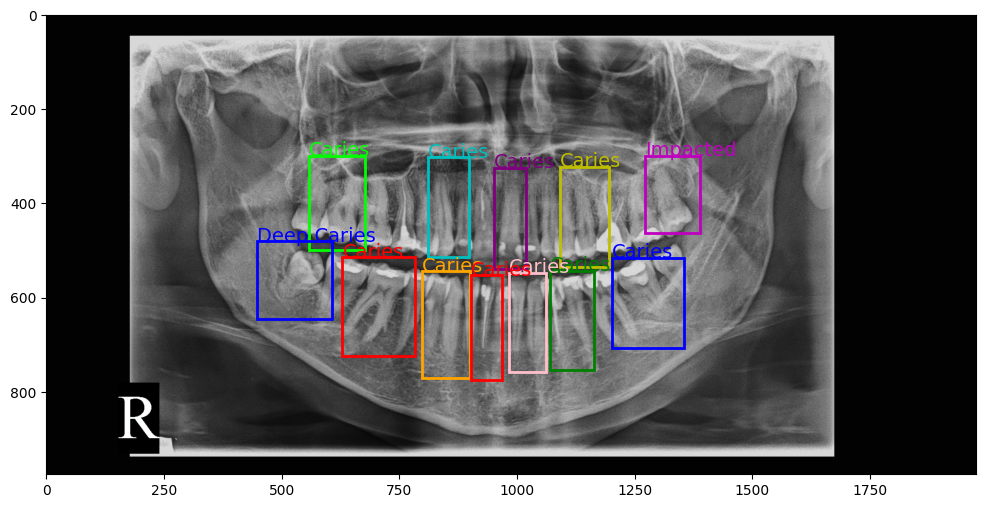

In [68]:
report = predict(model,'val_2.png')
report